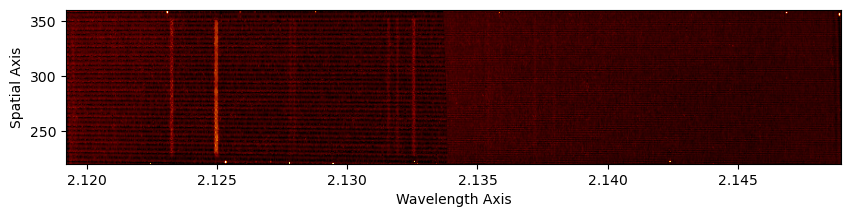

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit.models import PolynomialModel, QuadraticModel, LinearModel, ConstantModel
from lmfit import minimize, Parameters, fit_report

import os
import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('/Users/RuoyanWang/Documents/LEICESTER/h3p/code/')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')
plots_dir = os.path.abspath('./../../plots')+'/'

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load waverange
waverange = fits.open(filepath + 'order36/waverange.fits', ignore_missing_end=True)[0].data

# load skylines
skylines60m = fits.open(filepath + 'order36/skylines60m_order36.fits', ignore_missing_end=True)[0].data
skylines60p = fits.open(filepath + 'order36/skylines60p_order36.fits', ignore_missing_end=True)[0].data
skylines60p_shifted = fits.open(filepath + 'order36/skylines60p_shifted_order36.fits', ignore_missing_end=True)[0].data

spat_lower = 220
spat_upper = 360

plt.figure(figsize=(10,2))
# plt.imshow(skylines, cmap='gist_gray')
plt.imshow(skylines60m, aspect='auto', extent=[waverange[0], waverange[-1], spat_upper, spat_lower], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

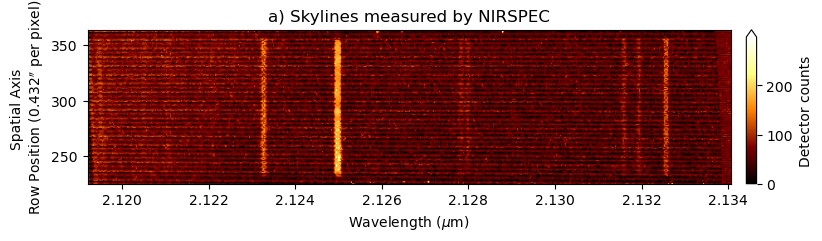

In [2]:
a = np.delete(skylines60m, np.s_[512:], 1)
a[a>350]=0
# pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
plt.figure(figsize=(10,2))
# plt.imshow(a, cmap='afmhot')
plt.imshow(a, aspect='auto', extent=[waverange[0], waverange[511], 364, 225], cmap='afmhot')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.title('a) Skylines measured by NIRSPEC')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Detector counts')

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 1024
    # variables        = 2
    chi-square         = 4.8220e-12
    reduced chi-square = 4.7182e-15
    Akaike info crit   = -33777.0481
    Bayesian info crit = -33767.1851
    R-squared          = 1.00000000
[[Variables]]
    slope:      2.9080e-05 +/- 7.2615e-12 (0.00%) (init = 2.908e-05)
    intercept:  2.11920261 +/- 4.2899e-09 (0.00%) (init = 2.119203)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.8658


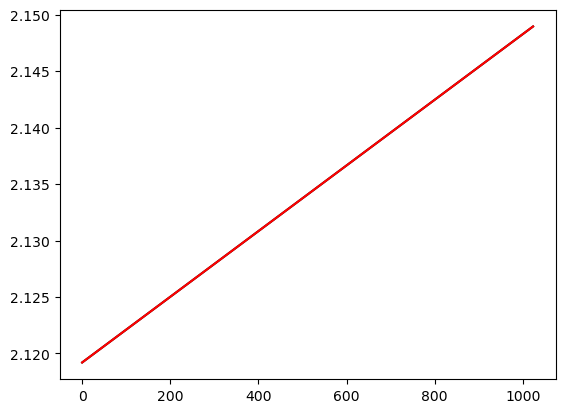

In [3]:
waveaxis = np.linspace(0, 1023, 1024)

mod = LinearModel()

pars = mod.guess(waverange, x=waveaxis)
out = mod.fit(waverange, pars, x=waveaxis)

print(out.fit_report(min_correl=0.25))

m = out.params['slope'].value
y0 = out.params['intercept'].value

wave_best_fit = m*waveaxis + y0

plt.figure()
plt.plot(waveaxis, waverange,'k', label = 'original')
plt.plot(waveaxis, wave_best_fit, 'r', label = 'best fit')

2.123241948610081
2.1249599552989324
2.1325969735600916


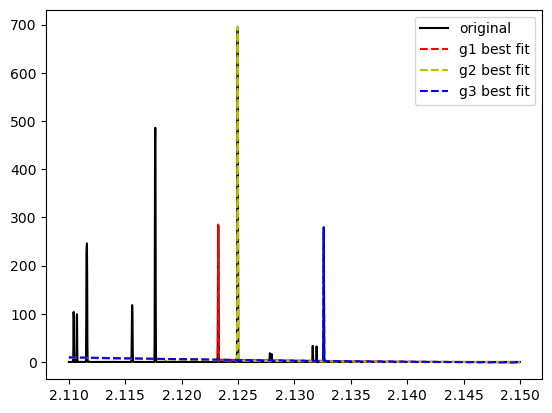

In [4]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[60500:62500,0]/1000)#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[60500:62500,1]#[gemini_array[60500:62500,1]>0.5]

plt.figure()
plt.plot(wavelength, count, 'k', label='original')
# plt.xlim(min(wavelength), max(wavelength))

# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=290)
g1_params.add('a1', value=2.12325)
g1_params.add('a2', value=0.003)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(count, g1_params, x=wavelength)
except:
    pass

#print(g1_result.fit_report())

plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
#plt.xlim(2.123,2.1235)

print(g1_result.params['a1'].value)

# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g2model.param_names))
#print('independent variables: {}'.format(g2model.independent_vars))


# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=692)
g2_params.add('a1', value=2.125)
g2_params.add('a2', value=0.004)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count, g2_params, x=wavelength)
except:
    pass

#print(g2_result.fit_report())

plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
#plt.xlim(2.1246,2.1252)

print(g2_result.params['a1'].value)

# create lmfit model with defined gaussian
g3_model = Model(gaussian_fit)

# create parameters and add initial guess
g3_params = g3_model.make_params()
g3_params.add('a0', value=290)
g3_params.add('a1', value=2.1326)
g3_params.add('a2', value=0.003)
g3_params.add('a3', value=0)
g3_params.add('a4', value=0)
g3_params.add('a5', value=0)

try:
    g3_result = g3_model.fit(count, g3_params, x=wavelength)
except:
    pass

#print(g3_result.fit_report())

plt.plot(wavelength, g3_result.best_fit, 'b--', label='g3 best fit')
plt.legend()
#plt.xlim(2.1315,2.133)

print(g3_result.params['a1'].value)

Text(0, 0.5, 'CCD Counts')

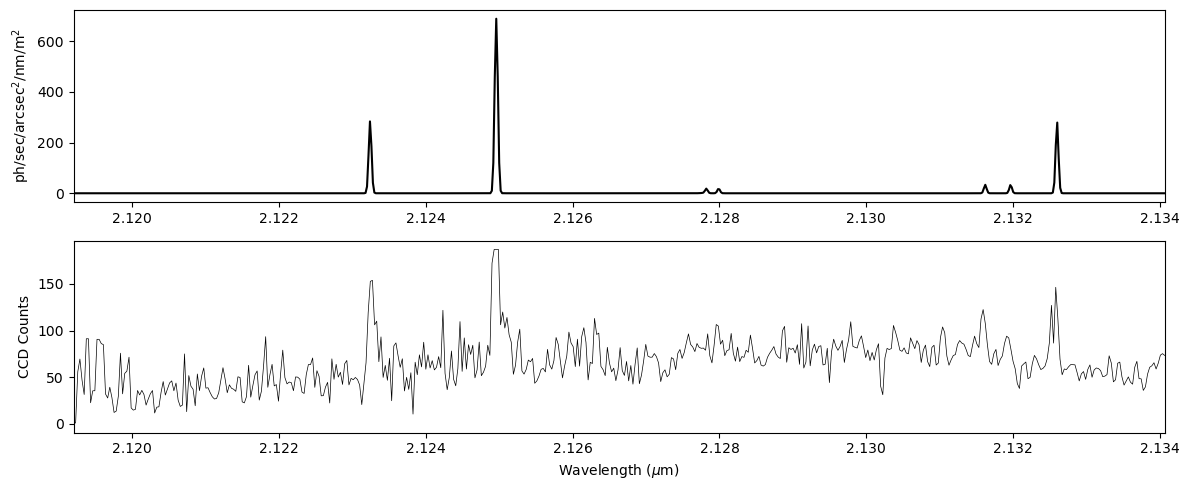

In [5]:
fig = plt.figure(figsize=(12,5), tight_layout=True)

fig.add_subplot(211)
plt.plot(wavelength, count, 'k', label='original')
# plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
# plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
# plt.plot(wavelength, g3_result.best_fit, 'b--', label='g3 best fit')
plt.xlim(waverange[0], waverange[511])
plt.ylabel('$\mathrm{ph/sec/arcsec^2/nm/m^2}$')
# plt.legend()

fig.add_subplot(212)
plt.plot(waverange[:512], a[50], 'k-', lw=0.5)
plt.xlim(waverange[0], waverange[511])
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('CCD Counts')

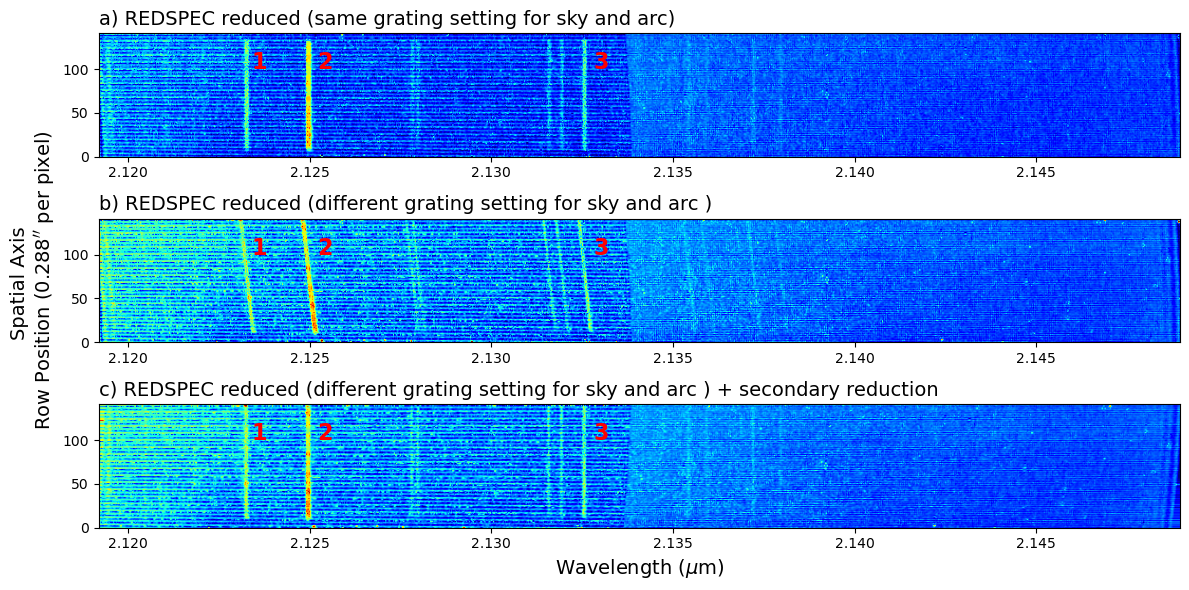

In [7]:
skylines = fits.open(filepath + 'order36/skylines60m_order36.fits', ignore_missing_end=True)[0].data
skylines60p = fits.open(filepath + 'order36/skylines60p_order36.fits', ignore_missing_end=True)[0].data
skylines_shifted = fits.open(filepath + 'order36/skylines60p_shifted_order36.fits', ignore_missing_end=True)[0].data

fig = plt.figure(figsize=(12,6), tight_layout=True)

tt = skylines
tt[tt>270]=0
fig.add_subplot(311)
plt.imshow(tt, 
           aspect='auto', 
           extent=[waverange[0], waverange[-1], 0, 141], 
           cmap='jet', 
           origin='lower')
# plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
# plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
# plt.plot(wavelength, g3_result.best_fit, 'b--', label='g3 best fit')
# plt.xlim(waverange[0], waverange[511])
# plt.ylabel('$\mathrm{ph/sec/arcsec^2/nm/m^2}$')
# plt.legend()
plt.title('a) REDSPEC reduced (same grating setting for sky and arc)', loc='left', fontsize=14)
# plt.xlabel('Wavelength ($\mu$m)')
# plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.text(2.1234,100, '1', c='r', size=16, weight='bold')
plt.text(2.1252,100, '2', c='r', size=16, weight='bold')
plt.text(2.1328,100, '3', c='r', size=16, weight='bold')

fig.add_subplot(312)
plt.imshow(skylines60p, 
           aspect='auto', 
           extent=[waverange[0], waverange[-1], 0, 141], 
           cmap='jet', 
           origin='lower')
plt.title('b) REDSPEC reduced (different grating setting for sky and arc )', loc='left', fontsize=14)
plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)', fontsize=14)
plt.text(2.1234,100, '1', c='r', size=16, weight='bold')
plt.text(2.1252,100, '2', c='r', size=16, weight='bold')
plt.text(2.1328,100, '3', c='r', size=16, weight='bold')

fig.add_subplot(313)
plt.imshow(skylines_shifted, 
           aspect='auto', 
           extent=[waverange[0], waverange[-1], 0, 141], 
           cmap='jet', 
           origin='lower')
plt.title('c) REDSPEC reduced (different grating setting for sky and arc ) + secondary reduction', loc='left', fontsize=14)
plt.xlabel('Wavelength ($\mu$m)', fontsize=14)
plt.text(2.1234,100, '1', c='r', size=16, weight='bold')
plt.text(2.1252,100, '2', c='r', size=16, weight='bold')
plt.text(2.1328,100, '3', c='r', size=16, weight='bold')

plt.savefig(plots_dir+'skyline_comparison', dpi=300, bbox_inches='tight', facecolor='white')

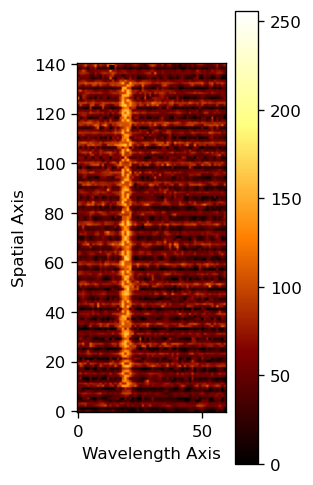

In [5]:
b = np.delete(a, np.s_[180:], 1)
c = np.delete(b, np.s_[:120], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(c, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

In [6]:
b = np.delete(a, np.s_[180:], 1)
c = np.delete(b, np.s_[:120], 1)
c = normalize(c)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[120:180]*100000

upper_skyline = 131
lower_skyline = 6

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):           
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.5)
        sky1_params.add('a1', value=212324)
        sky1_params.add('a2', value=5)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(c[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, c[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 125
    # variables        = 1
    chi-square         = 2.9442e-08
    reduced chi-square = 2.3744e-10
    Akaike info crit   = -2769.14339
    Bayesian info crit = -2766.31507
[[Variables]]
    c:  2.12324889 +/- 1.3782e-06 (0.00%) (init = 2.123249)


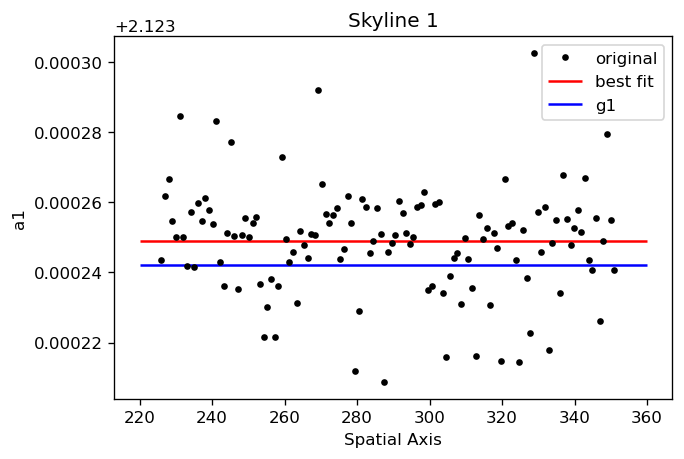

In [7]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))+220

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(spat_lower, spat_upper, 140)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_a1_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [8]:
sky1_a1_offset = sky1_a1_best_fit - g1_result.params['a1'].value
sky1_a1_offset 

6.87956233225151e-06

In [9]:
d = np.delete(a, np.s_[230:], 1)
e = np.delete(d, np.s_[:190], 1)
e = normalize(e)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[190:230]*100000

upper_skyline = 133
lower_skyline = 8

sky2_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):          
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.6)
        sky2_params.add('a1', value=212496)
        sky2_params.add('a2', value=2)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(e[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, e[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1[i-lower_skyline] = sky2_fit_result.params['a1'].value
sky2_a1 = sky2_a1/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 125
    # variables        = 1
    chi-square         = 5.2329e-09
    reduced chi-square = 4.2201e-11
    Akaike info crit   = -2985.07609
    Bayesian info crit = -2982.24778
[[Variables]]
    c:  2.12496076 +/- 5.8104e-07 (0.00%) (init = 2.124961)


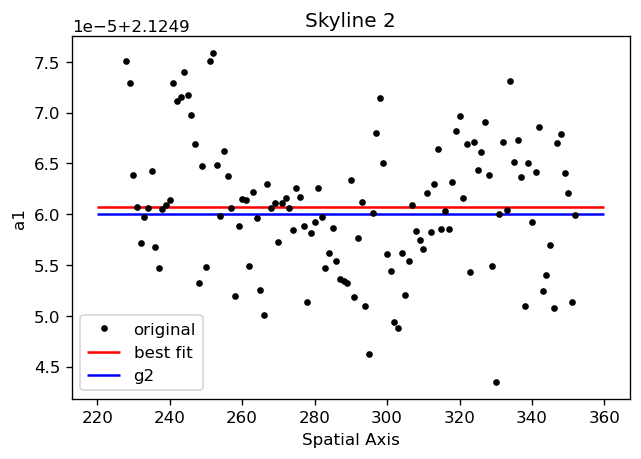

In [10]:
sky2_spat = np.linspace(lower_skyline, upper_skyline-1, len(sky2_a1))+220

x = sky2_spat
y = sky2_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_spat_all = np.linspace(spat_lower, spat_upper, 140)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky2_c = out.params['c'].value
sky2_a1_best_fit = sky2_c


plt.figure()
plt.plot(sky2_spat, sky2_a1,'.k', label = 'original')
plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
plt.hlines(g2_result.params['a1'].value, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g2')
plt.title('Skyline 2')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
# plt.ticklabel_format(useOffset=False)
plt.legend()

In [11]:
sky2_a1_offset = sky2_a1_best_fit - g2_result.params['a1'].value
sky2_a1_offset 

7.616494666073947e-07

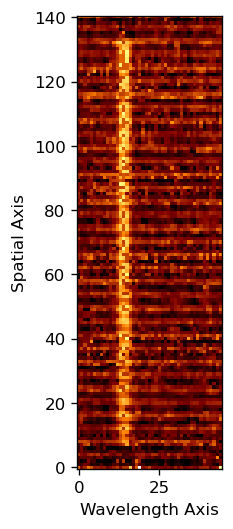

In [12]:
f = np.delete(a, np.s_[480:], 1)
g = np.delete(f, np.s_[:445], 1)

plt.figure(figsize=(2,5))
# plt.imshow(g, aspect='auto', extent=[waverange[445], waverange[480], 364, 225], cmap='afmhot')
plt.imshow(g, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.ticklabel_format(useOffset=False)
plt.gca().invert_yaxis()

In [13]:
f = np.delete(a, np.s_[480:], 1)
g = np.delete(f, np.s_[:445], 1)
#waveaxis = np.linspace(0, np.size(g, 1), np.size(g, 1))
waveaxis = waverange[445:480]*100000

upper_skyline = 133
lower_skyline = 8

sky3_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):            
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.7)
        sky3_params.add('a1', value=213256)
        sky3_params.add('a2', value=3)
        sky3_params.add('a3', value=0.2)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(g[i]), sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, normalize(g[i]))
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_a1 = sky3_a1/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 125
    # variables        = 1
    chi-square         = 4.1007e-08
    reduced chi-square = 3.3070e-10
    Akaike info crit   = -2727.72922
    Bayesian info crit = -2724.90091
[[Variables]]
    c:  2.13255017 +/- 1.6265e-06 (0.00%) (init = 2.13255)


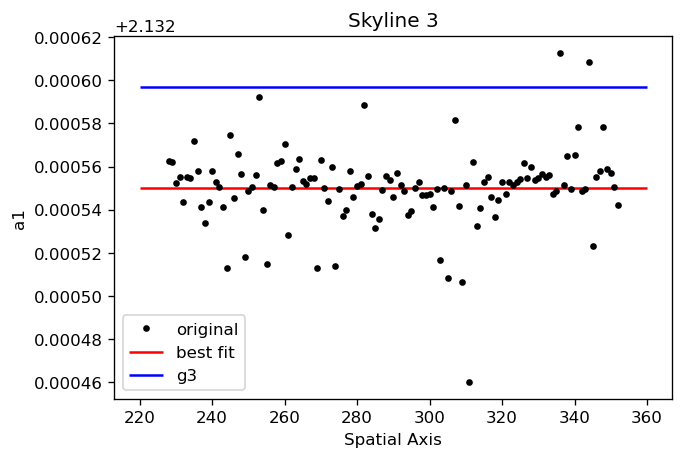

In [14]:
sky3_spat = np.linspace(lower_skyline, upper_skyline-1, len(sky3_a1))+220

x = sky3_spat
y = sky3_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(spat_lower, spat_upper, 140)
sky3_c = out.params['c'].value
sky3_a1_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_a1_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend(loc='lower left')

In [15]:
sky3_a1_offset = sky3_a1_best_fit - g3_result.params['a1'].value
sky3_a1_offset

-4.6823072529011966e-05

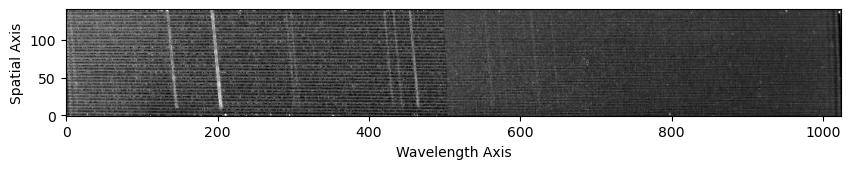

In [9]:
plt.figure(figsize=(10,2))
# plt.imshow(skylines, aspect='auto', extent=[0, 1089, 364, 225], cmap='gist_gray')
plt.imshow(skylines60p, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

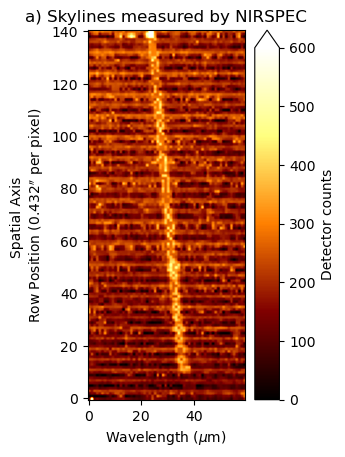

In [10]:
a = np.delete(skylines60p, np.s_[170:], 1)
b = np.delete(a, np.s_[:110], 1)

plt.figure()
plt.imshow(b, cmap='afmhot')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Spatial Axis \nRow Position (0.432$^{\prime\prime}$ per pixel)')
plt.title('a) Skylines measured by NIRSPEC')
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='Detector counts')

Error occured at i=118
Error occured at i=120
Error occured at i=124


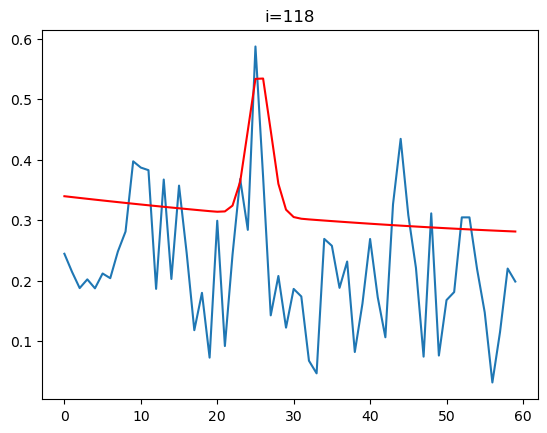

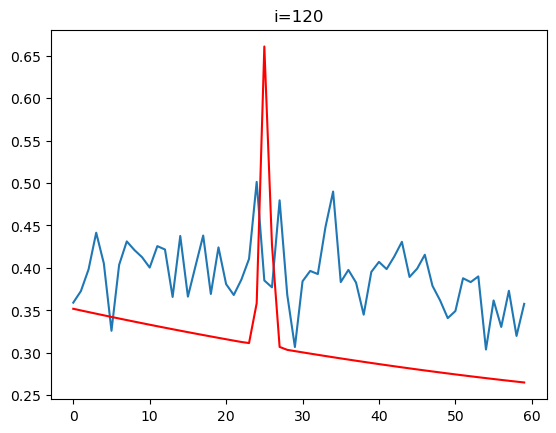

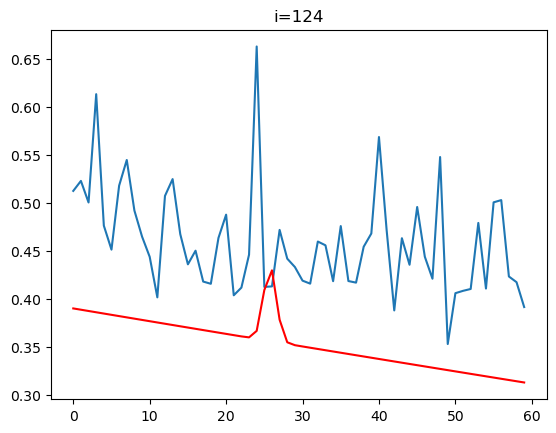

In [13]:
a = np.delete(skylines60p, np.s_[170:], 1)
b = np.delete(a, np.s_[:110], 1)

b = normalize(b)
waveaxis = np.linspace(0 ,np.size(b,1)-1, np.size(b,1))
# waveaxis = waverange[110:170]*100000

upper_skyline = 141
lower_skyline = 11

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= 130 and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=23)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 110 and i < 130:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=27)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 90 and i < 110:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=27)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 70 and i < 90:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=29)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= 50 and i < 70:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=31)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
        
    if i >= 30 and i < 50:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=32)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
            
    if i >= lower_skyline and i < 30:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=33)
        sky1_params.add('a2', value=2)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1+110

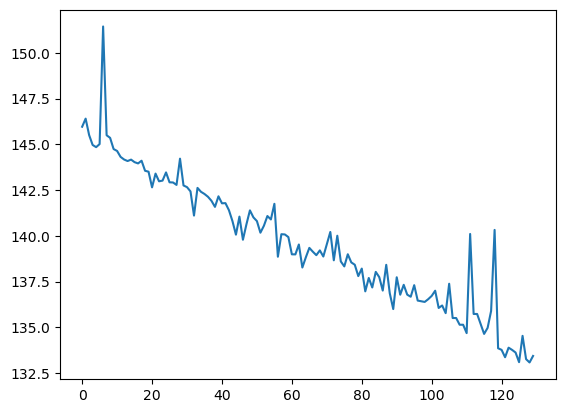

In [14]:
plt.plot(sky1_a1)

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 130
    # variables        = 2
    chi-square         = 140.899508
    reduced chi-square = 1.10077740
    Akaike info crit   = 14.4666216
    Bayesian info crit = 20.2016905
    R-squared          = 0.91581811
[[Variables]]
    slope:     -0.09079979 +/- 0.00243324 (2.68%) (init = -0.09079979)
    intercept:  166.462313 +/- 0.72609287 (0.44%) (init = 166.4623)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.9919


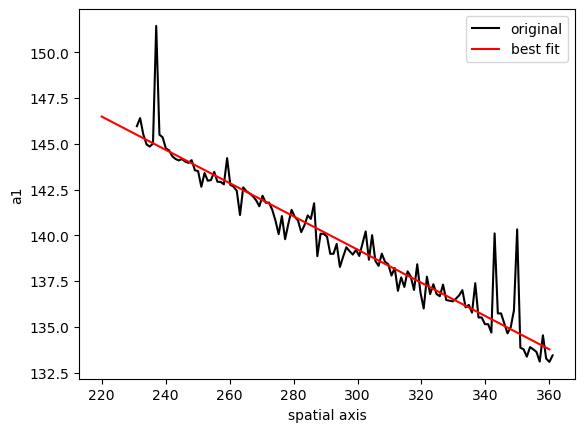

In [15]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))+220

x = sky1_spat
y = sky1_a1

mod = LinearModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

slope = out.params['slope'].value
intercept = out.params['intercept'].value

sky1_spat_all = np.linspace(220, 360, 141)
sky1_a1_best_fit = slope*sky1_spat_all + intercept

plt.figure()
plt.plot(sky1_spat, sky1_a1,'k', label = 'original')
plt.plot(sky1_spat_all, sky1_a1_best_fit, 'r', label = 'best fit')
plt.xlabel('spatial axis')
plt.ylabel('a1')
plt.ticklabel_format(useOffset=False)
plt.legend()

In [35]:
g1_result.params['a1'].value, g2_result.params['a1'].value, g3_result.params['a1'].value

(2.1232419486100724, 2.1249599552989284, 2.1325969735600894)

In [38]:
(g1_result.params['a1'].value-y0)/m

138.90431798512077

In [17]:
sky1_pixel_offset_order36 = 138.90636616417416 - sky1_a1_best_fit
# np.savetxt('sky1_pixel_offset_order36.txt', sky1_pixel_offset_order36)
sky1_pixel_offset_order36

array([-7.57999399, -7.48919421, -7.39839442, -7.30759464, -7.21679485,
       -7.12599507, -7.03519528, -6.94439549, -6.85359571, -6.76279592,
       -6.67199614, -6.58119635, -6.49039657, -6.39959678, -6.308797  ,
       -6.21799721, -6.12719742, -6.03639764, -5.94559785, -5.85479807,
       -5.76399828, -5.6731985 , -5.58239871, -5.49159892, -5.40079914,
       -5.30999935, -5.21919957, -5.12839978, -5.0376    , -4.94680021,
       -4.85600043, -4.76520064, -4.67440085, -4.58360107, -4.49280128,
       -4.4020015 , -4.31120171, -4.22040193, -4.12960214, -4.03880235,
       -3.94800257, -3.85720278, -3.766403  , -3.67560321, -3.58480343,
       -3.49400364, -3.40320386, -3.31240407, -3.22160428, -3.1308045 ,
       -3.04000471, -2.94920493, -2.85840514, -2.76760536, -2.67680557,
       -2.58600579, -2.495206  , -2.40440621, -2.31360643, -2.22280664,
       -2.13200686, -2.04120707, -1.95040729, -1.8596075 , -1.76880771,
       -1.67800793, -1.58720814, -1.49640836, -1.40560857, -1.31

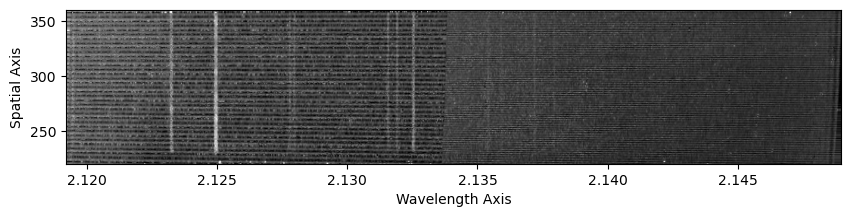

In [40]:
plt.figure(figsize=(10,2))
plt.imshow(skylines60p_shifted, aspect='auto', extent=[waverange[0], waverange[-1], 360, 220], cmap='gist_gray')
# plt.imshow(skylines, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

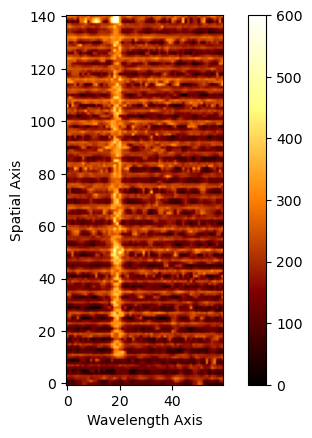

In [46]:
a = np.delete(skylines60p_shifted, np.s_[180:], 1)
b = np.delete(a, np.s_[:120], 1)

plt.figure()
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

Error occured at i=116
Error occured at i=120


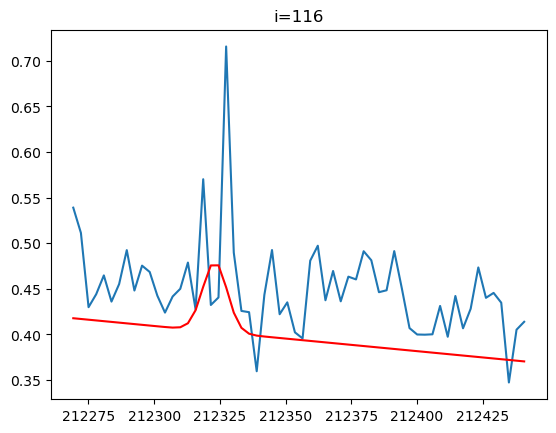

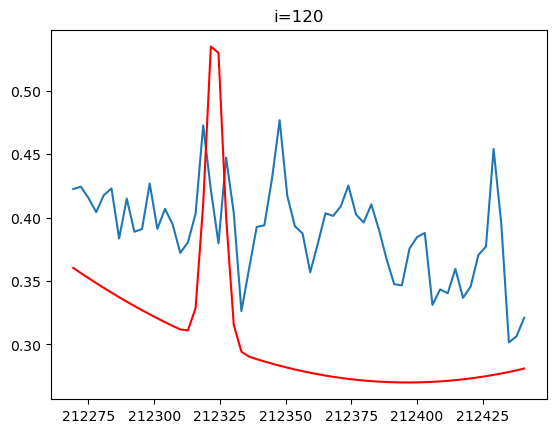

In [49]:
a = np.delete(skylines60p_shifted, np.s_[180:], 1)
b = np.delete(a, np.s_[:120], 1)
b = normalize(b)
waveaxis = waverange[120:180]*100000

upper_skyline = 141
lower_skyline = 10

sky1_wave = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=212324, min=212315)
        sky1_params.add('a2', value=3)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_wave[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_wave = sky1_wave/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 131
    # variables        = 1
    chi-square         = 3.6513e-08
    reduced chi-square = 2.8087e-10
    Akaike info crit   = -2880.10374
    Bayesian info crit = -2877.22854
    R-squared          = 0.00000000
[[Variables]]
    c:  2.12323558 +/- 1.4643e-06 (0.00%) (init = 2.123236)


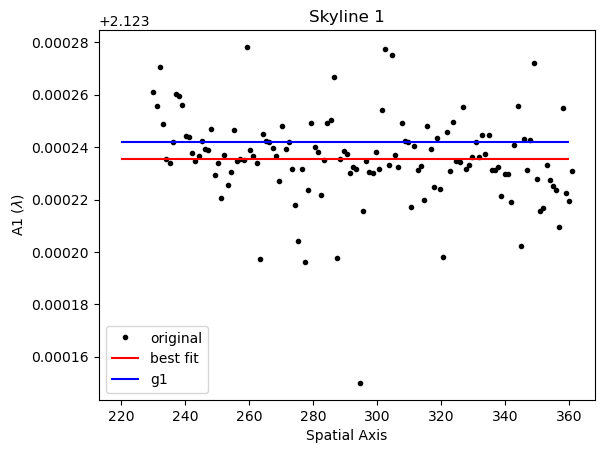

In [50]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_wave))+220

x = sky1_spat
y = sky1_wave

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(220, 360, 141)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_wave_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_wave_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 ($\lambda$)')
plt.legend()

Error occured at i=118
Error occured at i=121
Error occured at i=123
Error occured at i=124


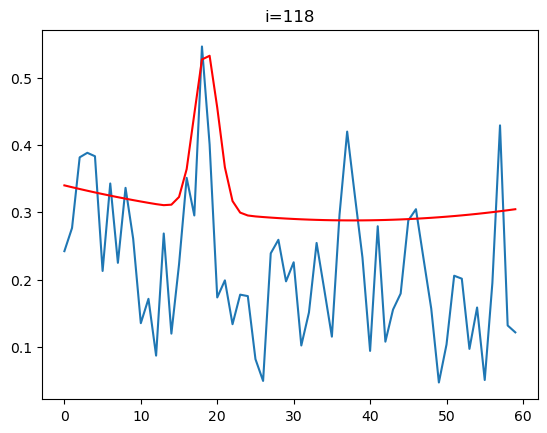

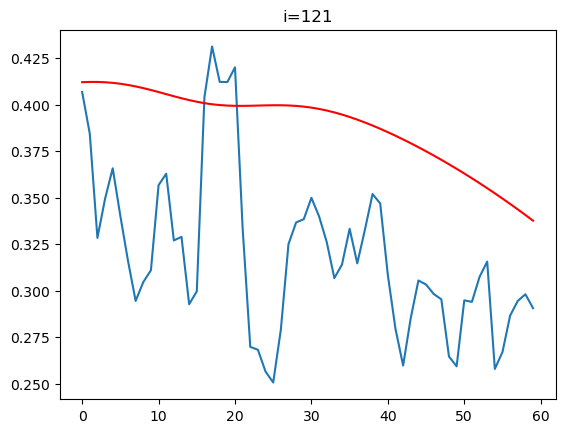

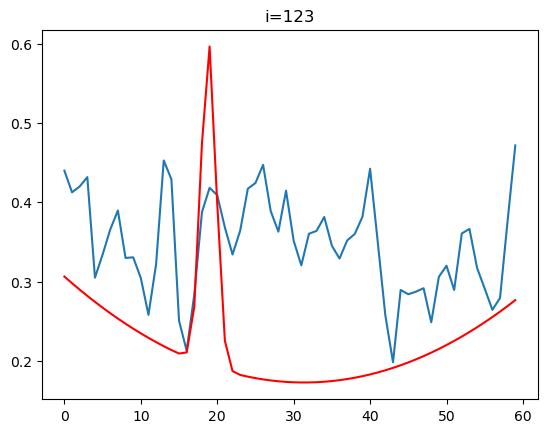

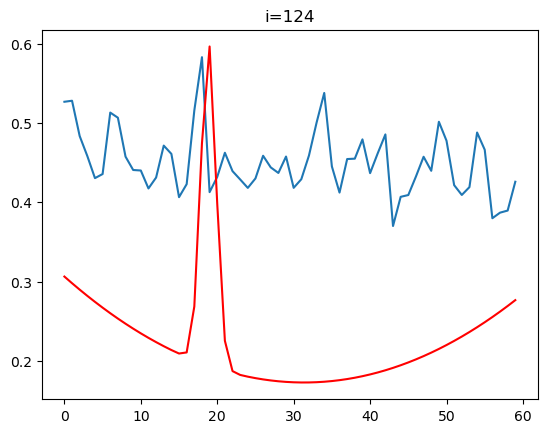

In [51]:
a = np.delete(skylines60p_shifted, np.s_[180:], 1)
b = np.delete(a, np.s_[:120], 1)
b = normalize(b)
# waveaxis = waverange[120:180]*100000
waveaxis = np.linspace(0 ,np.size(b,1)-1, np.size(b,1))

upper_skyline = 141
lower_skyline = 10

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=19, min=17, max=21)
        sky1_params.add('a2', value=3)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1+120

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 131
    # variables        = 1
    chi-square         = 43.1421193
    reduced chi-square = 0.33186246
    Akaike info crit   = -143.501380
    Bayesian info crit = -140.626183
    R-squared          = 0.00000000
[[Variables]]
    c:  138.682268 +/- 0.05033191 (0.04%) (init = 138.6823)


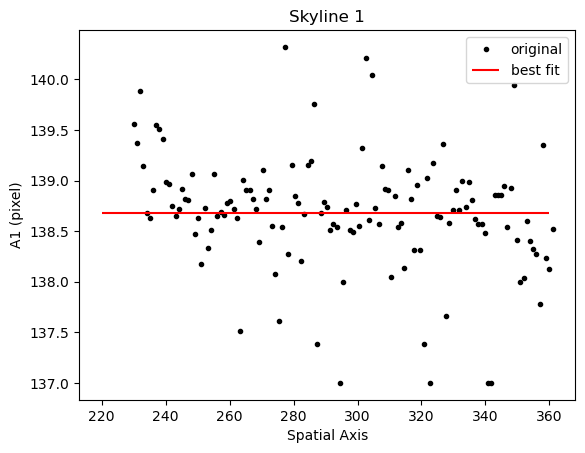

In [52]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_wave))+220

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(220, 360, 141)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_a1_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
# plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 (pixel)')
plt.legend()

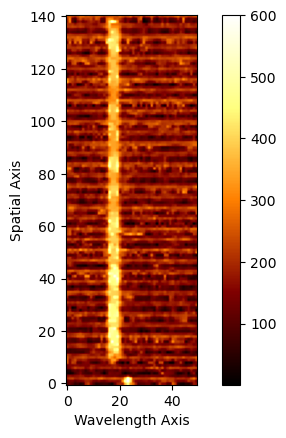

In [53]:
c = np.delete(skylines60p_shifted, np.s_[230:], 1)
d = np.delete(c, np.s_[:180], 1)

plt.figure()
plt.imshow(d, cmap='afmhot')
# plt.imshow(d, aspect='auto', extent=[waverange[120], waverange[209], 364, 225], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()
# plt.ylim(0,10)

In [54]:
c = np.delete(skylines60p_shifted, np.s_[230:], 1)
d = np.delete(c, np.s_[:180], 1)
d = normalize(d)
waveaxis = waverange[180:230]*100000

upper_skyline = 141
lower_skyline = 10

sky2_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):          
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.6)
        sky2_params.add('a1', value=212496)
        sky2_params.add('a2', value=2)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(d[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1[i-lower_skyline] = sky2_fit_result.params['a1'].value
sky2_a1 = sky2_a1/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 131
    # variables        = 1
    chi-square         = 1.5871e-08
    reduced chi-square = 1.2208e-10
    Akaike info crit   = -2989.24963
    Bayesian info crit = -2986.37443
    R-squared          = 0.00000000
[[Variables]]
    c:  2.12494963 +/- 9.6537e-07 (0.00%) (init = 2.12495)


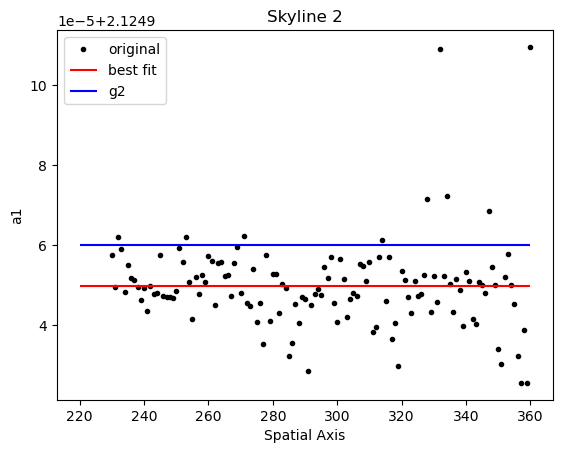

In [55]:
sky2_spat = np.linspace(lower_skyline, upper_skyline-1, len(sky2_a1))+220

x = sky2_spat
y = sky2_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_spat_all = np.linspace(220, 360, 141)
sky2_c = out.params['c'].value
sky2_a1_best_fit = sky2_c


plt.figure()
plt.plot(sky2_spat, sky2_a1,'.k', label = 'original')
plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
plt.hlines(g2_result.params['a1'].value, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g2')
plt.title('Skyline 2')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
# plt.ticklabel_format(useOffset=False)
plt.legend()

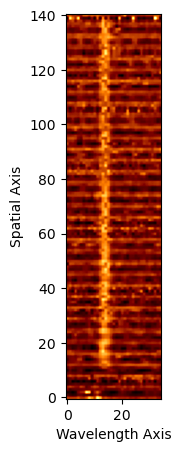

In [56]:
e = np.delete(skylines60p_shifted, np.s_[480:], 1)
f = np.delete(e, np.s_[:445], 1)

plt.figure(figsize=(2,5))
# plt.imshow(g, aspect='auto', extent=[waverange[445], waverange[480], 364, 225], cmap='afmhot')
plt.imshow(f, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.ticklabel_format(useOffset=False)
plt.gca().invert_yaxis()

Error occured at i=62
Error occured at i=66
Error occured at i=87
Error occured at i=99
Error occured at i=104
Error occured at i=116
Error occured at i=139


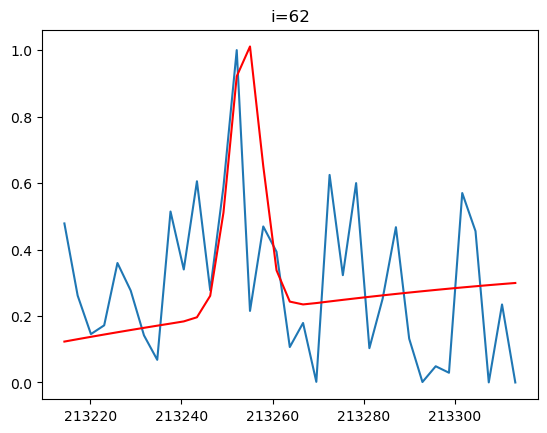

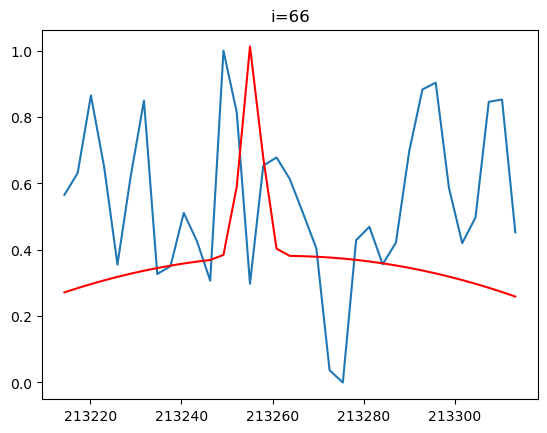

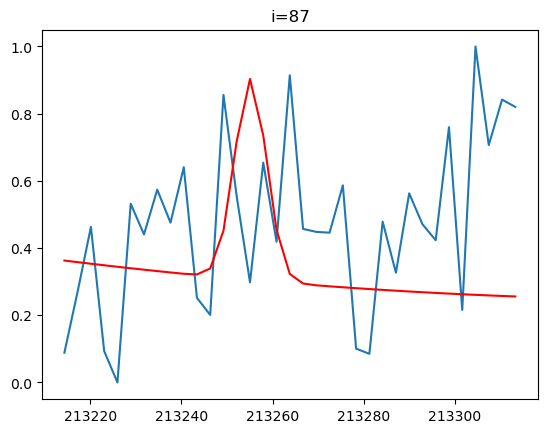

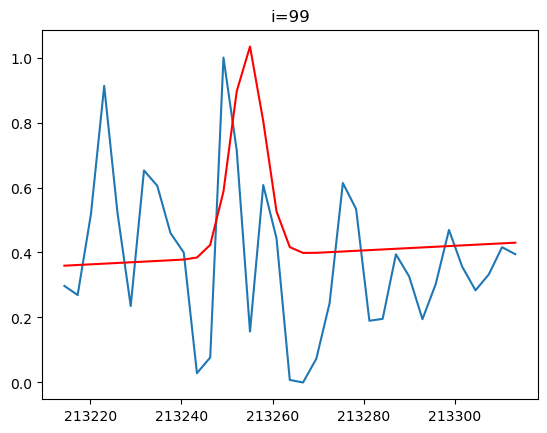

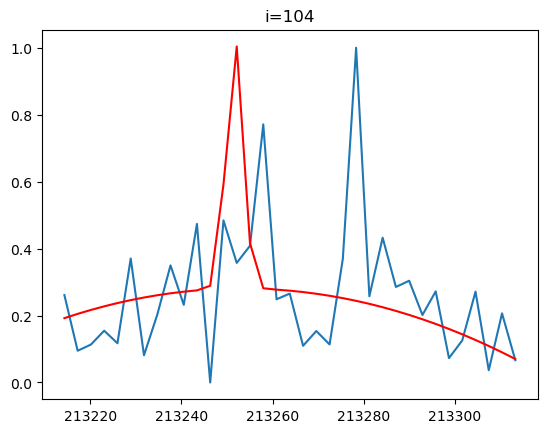

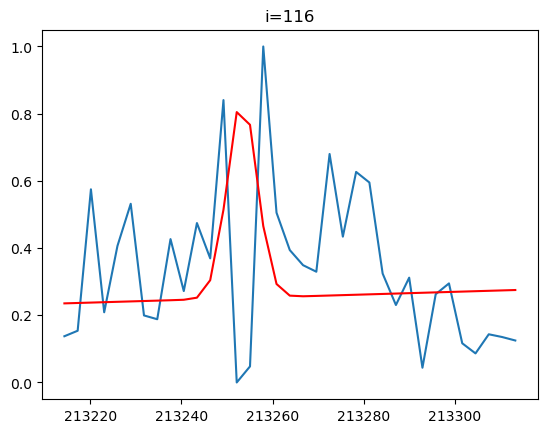

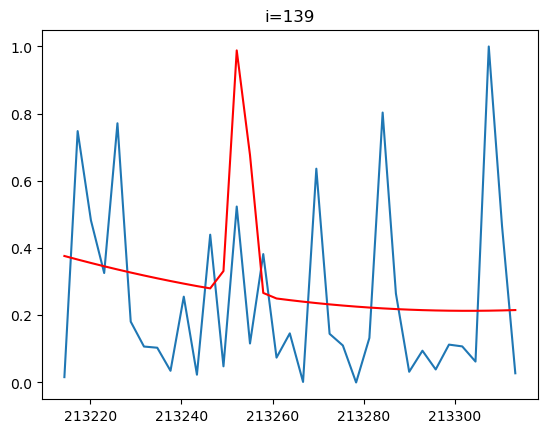

In [57]:
e = np.delete(skylines60p_shifted, np.s_[480:], 1)
f = np.delete(e, np.s_[:445], 1)
f = normalize(f)
waveaxis = waverange[445:480]*100000

upper_skyline = 141
lower_skyline = 10

sky3_wave = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):            
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.7)
        sky3_params.add('a1', value=213256, min=213247, max=213262)
        sky3_params.add('a2', value=3)
        sky3_params.add('a3', value=0.2)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(f[i]), sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, normalize(f[i]))
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_wave[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_wave = sky3_wave/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 131
    # variables        = 1
    chi-square         = 5.0327e-08
    reduced chi-square = 3.8713e-10
    Akaike info crit   = -2838.07011
    Bayesian info crit = -2835.19491
    R-squared          = 0.00000000
[[Variables]]
    c:  2.13254214 +/- 1.7191e-06 (0.00%) (init = 2.132542)


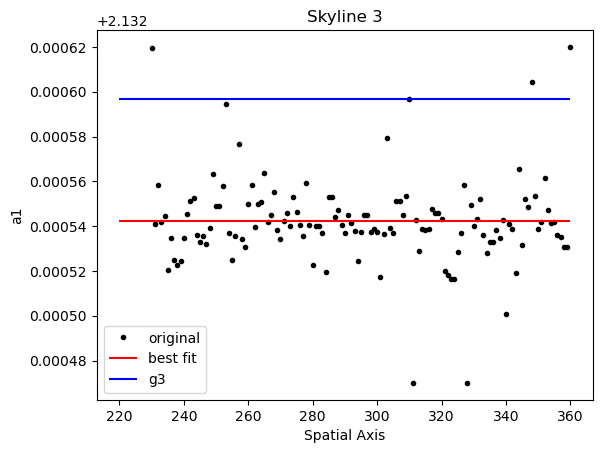

In [58]:
sky3_spat = np.linspace(lower_skyline, upper_skyline-1, len(sky3_wave))+220

x = sky3_spat
y = sky3_wave

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(220, 360, 141)
sky3_c = out.params['c'].value
sky3_wave_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_wave_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend(loc='lower left')

Error occured at i=33
Error occured at i=89
Error occured at i=117
Error occured at i=120
Error occured at i=140


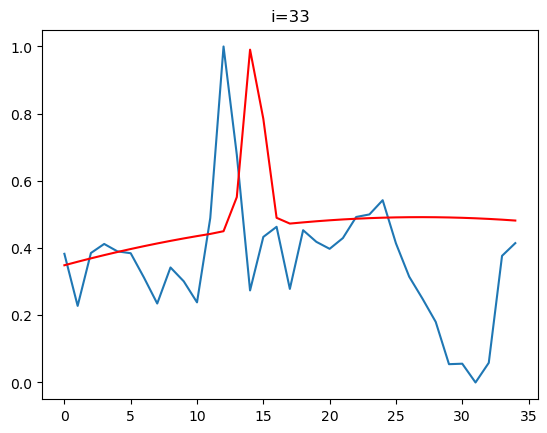

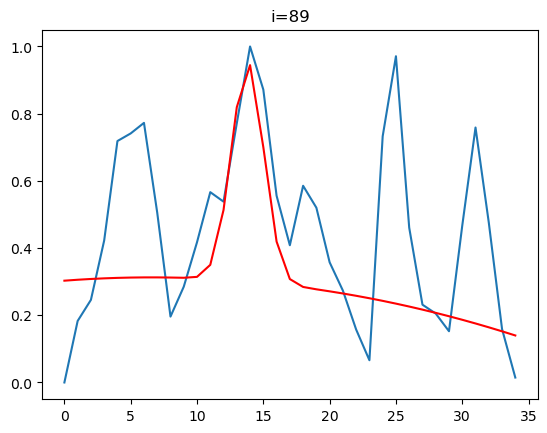

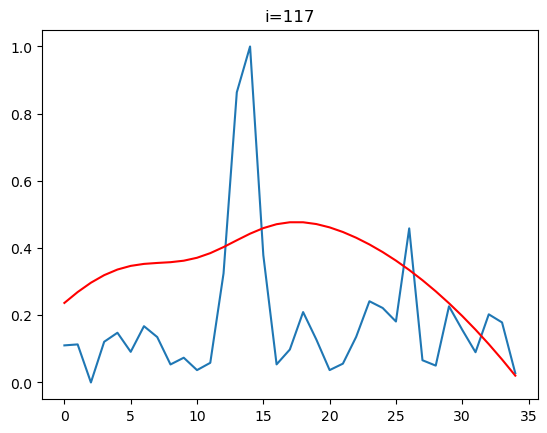

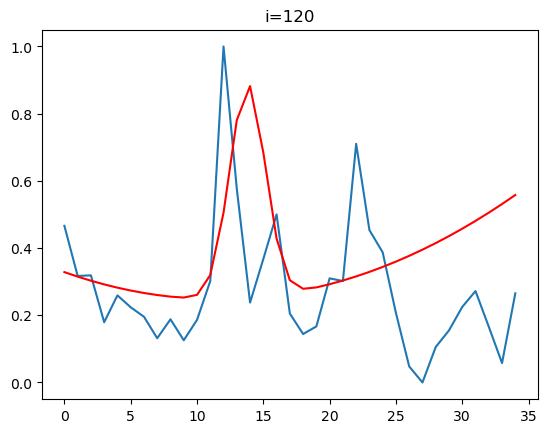

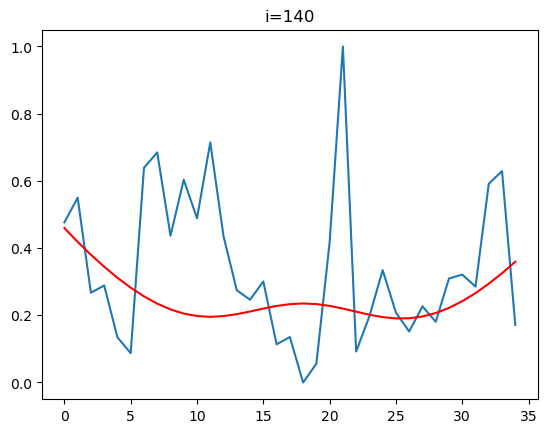

In [59]:
e = np.delete(skylines60p_shifted, np.s_[480:], 1)
f = np.delete(e, np.s_[:445], 1)
f = normalize(f)
# waveaxis = waverange[445:480]*100000
waveaxis = np.linspace(0 ,np.size(f,1)-1, np.size(f,1))

upper_skyline = 141
lower_skyline = 10

sky3_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):            
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.7)
        sky3_params.add('a1', value=13, min=10)
        sky3_params.add('a2', value=3)
        sky3_params.add('a3', value=0.2)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(f[i]), sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, normalize(f[i]))
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_a1 = sky3_a1+445

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 131
    # variables        = 1
    chi-square         = 417.245859
    reduced chi-square = 3.20958353
    Akaike info crit   = 153.760659
    Bayesian info crit = 156.635857
    R-squared          = 0.00000000
[[Variables]]
    c:  458.794772 +/- 0.15652680 (0.03%) (init = 458.7948)


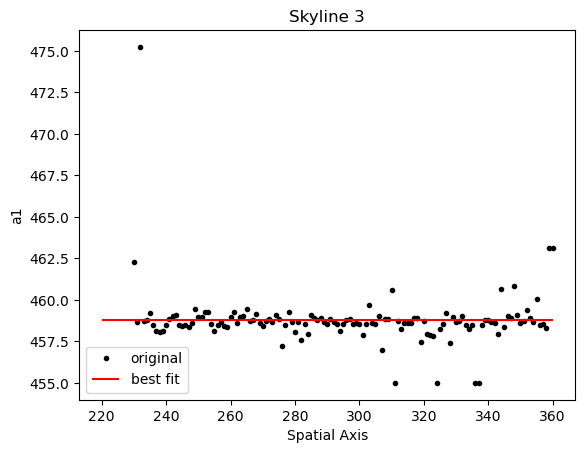

In [60]:
sky3_spat = np.linspace(lower_skyline, upper_skyline-1, len(sky3_a1))+220

x = sky3_spat
y = sky3_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(220, 360, 141)
sky3_c = out.params['c'].value
sky3_a1_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_a1_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
# plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend(loc='lower left')

In [66]:
print(sky1_wave_best_fit)
print(sky3_wave_best_fit)
print(sky1_a1_best_fit)
print(sky3_a1_best_fit)

R = (sky1_wave_best_fit + sky3_wave_best_fit)*0.5/((sky3_wave_best_fit - sky1_wave_best_fit)/(sky3_a1_best_fit - sky1_a1_best_fit))
# np.savetxt('resolution.txt', R)
R

2.123235577196722
2.132542136594219
138.6822676609474
458.7947720081967


73191.79966085296

In [62]:
((sky3_wave_best_fit - sky1_wave_best_fit)/(sky3_a1_best_fit - sky1_a1_best_fit))

2.9072776824117137e-05

In [63]:
waverange

array([2.1192026, 2.1192317, 2.1192608, ..., 2.1488934, 2.1489224,
       2.1489515], dtype='>f4')